In [37]:
"""
https://arxiv.org/abs/1711.00937
"""

from ai.vqvae.model import VQVAE
from torchvision.datasets import MNIST, FashionMNIST
import torch
import torch.functional as F
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from einops import rearrange
import torchvision
from torch.optim import AdamW
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
device = torch.device('cuda')
model = VQVAE(VQVAE.Config(n_embd=2)).to(device)
    
num_epochs = 1
optimizer = AdamW(model.parameters(), lr=1E-3)
criterion = torch.nn.MSELoss()

for epoch_idx in range(num_epochs):
    for im, label in tqdm(train_dataloader):
        im = im.float().to(device)
        optimizer.zero_grad()
        out, quantize_loss, tokens = model(im)
        
        recon_loss = criterion(out, im)
        loss = recon_loss + quantize_loss
        loss.backward()
        optimizer.step()
    print('Finished epoch {}'.format(epoch_idx+1))
print('Done Training...')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 84.38it/s]

Finished epoch 1
Done Training...


Done Reconstruction ...


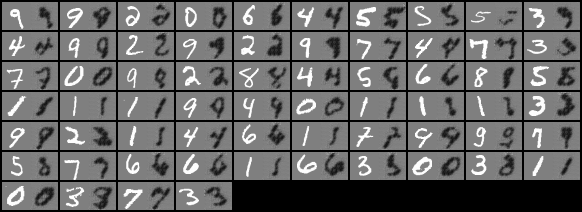

In [39]:
# Reconstruction part

for ims, y in test_dataloader:
    ims = ims.to(device)
    model.eval()
    
    
    generated_im, _,_ = model(ims)
    ims = (ims+1)/2
    generated_im = 1 - (generated_im+1)/2
    out = torch.hstack([ims, generated_im])
    output = rearrange(out, 'b c h w -> b () h (c w)')
    grid = torchvision.utils.make_grid(output.detach().cpu(), nrow=10)
    img = torchvision.transforms.ToPILImage()(grid)
    img.save('reconstruction.png')
    
    print('Done Reconstruction ...')
    break
from IPython import display
display.Image('reconstruction.png')    

In [36]:
x = im
self = model

In [185]:
# self.pre_quant_conv(encoded_output).shape

In [190]:
# set(map(float,min_encoding_indices.ravel()))

In [192]:
# B, C, H, W
encoded_output = self.encoder(x)
quant_input = self.pre_quant_conv(encoded_output)

## Quantization
B, C, H, W = quant_input.shape
quant_input = rearrange(quant_input, 'b c h w -> b (h w) c')

# B,H*W,3; Compute pairwise distances to each embedding
dist = torch.cdist(quant_input, self.embedding.weight.repeat((B, 1, 1)))

# (B,H*W) Find index of nearest embedding
min_encoding_indices = torch.argmin(dist, dim=-1)

# Select the embedding weights
quant_out = self.embedding.weight[min_encoding_indices.view(-1)]

# flatten
quant_input = rearrange(quant_input, 'b (h w) c -> (b h w) c', h=H,w=W)

# Compute losses
# train encoder weights
commitment_loss = torch.mean((quant_out.detach() - quant_input) ** 2)
# train codebook
codebook_loss = torch.mean((quant_out - quant_input.detach()) ** 2)
# mix losses
quantize_losses = codebook_loss + self.beta * commitment_loss

# Ensure straight through gradient
quant_out = quant_input + (quant_out - quant_input).detach()

# Reshaping back to original input shape
quant_out = rearrange(quant_out, '(b h w) c -> b c h w', h=H, w=W)
min_encoding_indices = rearrange(min_encoding_indices, 'b (h w) -> b h w', h=H,w=W)

# Decoder part
decoder_input = self.post_quant_conv(quant_out)
output = self.decoder(decoder_input)

In [193]:
output[:2,:2,:2,:2]

tensor([[[[ 0.0080, -0.0030],
          [-0.0035, -0.0057]]],


        [[[ 0.0080, -0.0030],
          [-0.0035, -0.0057]]]], device='cuda:0', grad_fn=<SliceBackward0>)

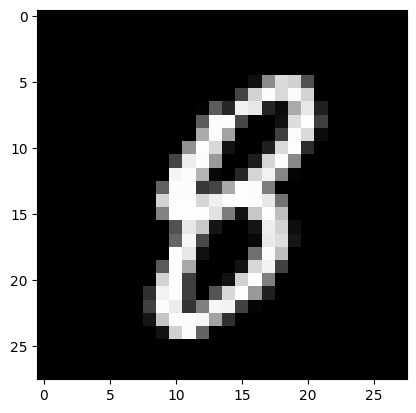

In [235]:
import matplotlib.pyplot as plt
x = ims[0].cpu().detach().numpy().reshape(28,28)
plt.imshow(x, cmap='grey')